---
# <div align="center"><font color='green'> COSC 2753 | Machine Learning  </font></div>
## <div align="center"> <font color='green'> Week 4 Lab Exercises: **Polynominal Regression and k-fold Cross Validation**</font></div>
---

# Introduction

Last weeks we learned how to read the data, do exploratory data analysis (EDA), split data, feed the data to a learning algorithm. 

The lab assumes that you have completed ``Week 02 lab: Reading data & Exploratory Data Analysis (EDA)`` and ``Week 03 lab: Training a Regression Model``. If you haven't yet, please do so before attempting this lab. 

In this lab, we will practise performing k-fold cross validation and use it to find the best regularisation parameter for a lasso polynomial regression model.

> **<span style="font-size:1.5em;">⚠</span> Warning: Starting this week, we will progressively provide less code, and would like you to use previous labs and what you know to perform the tasks. This will help you to become proficient at this.**

The lab can be executed on either your own machine (with anaconda installation) or computer lab. 
- Please refer canvas for instructions on installing anaconda python


## Objective

- Continue to familiarise with Python and other ML packages
- Practice polynomial regression
- Practice performing k-fold cross validation
- Use validation set to find best regularisation parameter


## Dataset


We contineously examine two regression based datasets in this lab. The first one is to do with house prices, some factors
associated with the prices and trying to predict house prices. The second dataset is predicting the amount of
share bikes hired every day in Washington D.C., USA, based on time of the year, day of the week and weather
factors. These datasets are available in `housing.data.csv` and `bikeShareDay.csv` in the code repository. 

First, ensure the two data files are located within the Jupyter workspace. 

- If you are on the local machine copy the two data data directories (`BostonHousingPrice`,`Bike-Sharing-Dataset`) to your current folder.

In this course we mostly use datasets that are collected by a third party. If you are interested in collecting your own data for your project, some useful information can be found at: [Introduction to Constructing Your Dataset](https://developers.google.com/machine-learning/data-prep/construct/construct-intro) 

# Problem Formulation

The first step in developing a model is to formulate the problem in a way that we can apply machine learning. To reiterate, the `task` in the Boston house price dataset is to predict the house price (`MEDV`), using some attributes of the house and neighbourhood. 

<span style="font-size:1.5em;">�</span> Observe the data and see if there is a pattern that would allow us to predict the house price using the attributes given? You can use the observations from the EDA for this.

<span style="font-size:1.5em;">�</span> What category does the task belong to?
> <span style="font-size:1em;">✔</span> **Task category:** 
> - supervised, univariate/multivariate regression 

> - We should use the insights gained from observing the data (EDA) in selecting the performance measure. e.g. are there outliers in target?

# Load dataset 

Start a new Jupyter notebook session. Load the dataset ‘housing.data.csv’in bostonHouseFrame

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## TODO
bostonHouseFrame = pd.read_csv("housing.data.csv", delimiter="\s+")
print(bostonHouseFrame)


        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273.0   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273.0   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273.0   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273.0   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273.0   

     PTRATIO       B  LSTAT  MEDV  
0       15.3  396.90   4.98  24.0  
1       17.8  396.90   9.14

# Univariate Regression
We will first study how to do univariate regression.

If you recall from the last lab, we found that possibly the ‘RM’ (number of rooms) and ‘LSTAT’ (unsure) variables seem to have a linear relationship with the house price (‘MEDV’). Hence, we will try these variables as the independent variable to predict the house price, i.e., the dependent variable.



- Create an independent variable that is just based on the ‘RM’ column and a dependent variable of ‘MEDV’. 
- Assign the values of the 'RM' column to a variable named 'house_uniRM_x' and assign the values of the 'MEDV' column to a variable named 'house_y'.

<span style="font-size:1.5em;">�</span> There are at least three ways to create the house_uniRM_x and house_y variables based on those columns. Do some quick online research to slice the bostonHousePrice dataset and extract the two columns, by using the following methods: 
- (1) using square brackets []
- (2) using the pandas function .loc
- (3) using the pandas function .iloc

In [127]:
#print(bostonHouseFrame)
#house_uniRM_x = bostonHouseFrame.loc[:,'RM']
#house_uniRM_x= house_uniRM_x.values.reshape(-1,1)
house_uniRM_x = bostonHouseFrame[['RM']]
house_y = bostonHouseFrame['MEDV']

In [128]:
print(house_y)
print(house_uniRM_x.shape)

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64
(506, 1)


# Hold-out Validation 

As we have discussed in the lecture, in supervised learning we are interested in learning a model using our dataset that can predict the target value for unseen data (Not in the training set). This is called **generalization**. How can we test if the model we developed with our training data would generalize? One approach we can use is to **hold some data from the training process - hold-out validation** (Hypothetical unseen data). This hold out data subset (split) is called the `"Test set"` and the remaining data is called the `”Training set"`. The training set may be further subdivided, but more on this later in the regularization lecture. We can use the "Test set" at the end of the development phase to test our model and see if it generalizes.  

- **Training set:** Is applied to train, or fit, your model. For example, you use the training set to find the optimal weights, or coefficients, for linear regression, logistic regression, or neural networks.
- **Test set:** Needed for an unbiased evaluation of the final model.


> **<span style="font-size:1.5em;">⚠</span> Warning: The test set should be independent and identically distributed with respect to the training data**  
> - Should make sure that there is no leakage between the two sets (overlapped train and test instances). This will give unrealistically high performance metric values for your model. e.g. In house price prediction, there may be a house that was sold multiple times and, you might include some instances of this house in the train set and some in the test set. This will result in data leakage.  
> - There should be no underlying differences between the two distributions. In other words the characteristics of the test set should not be different to that of the train set. For example all the houses sold in winter in train set and all the houses sold on summer in another set (generally, there is a difference in house prices sold in winter vs summer).
> - More on this in the lectures. 

> **<span style="font-size:1.5em;">⚠</span> Warning: The test data should NOT be used for any aspect of the model development process (training).**  
> This includes hyper parameter tuning and model selection (a separate validation set should be used for them).  

Next, we want to create some data to train the model, and some other data to evaluate how good the model is. We may be tempted to use 100% of the data for training, then select a subset for evaluation (say 20% of the data). However, we will find out later that this isn’t a good idea generally, as the data we use to test is the same we use to train, and likely to cause overfitting and what is called bias. We will discuss this more in a later week, but for now, just note that it isn’t a good idea to do so. 

Instead, we will split the data into a training set, which we use to fit the model/hypothesis, and a testing set, which we will use to evaluate the performance of the fitted model/hypothesis. There should be no overlap between the two sets. How we achieve this is typically randomly split the data, say 80% for training and 20% for testing. We can do this ourselves, but like many machine learning functionality these days, they are already implemented, and of course, they are available in the libraries we have imported.

The scikit-learn Python machine learning library provides an implementation of the train-test splitting via function `train_test_split()`. Lets use this to randomly split our data to 80% train set and 20% test set.

In [129]:
# create testing and training data for RM variable
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(house_uniRM_x, house_y, test_size=0.2,shuffle=True)
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(404, 1)
(102, 1)
(404,)
(102,)


The function that does the work is ‘train_test_split()’, part of sklearn.model_selection package. It essentially does what we desire, with the first two arguments to it are the X and Y variable datasets respectively (they must be of the same number of rows/instances), and a test_size parameter which specifies how big the test dataset is (in this case, 20% of the data, which is a typical setting for this). This function returns ‘trainX’ (training data of the X variable), ‘testX’ (testing data of X), ‘trainY’ (training data of Y) and ‘testY’ (testing data of Y). The last four statements just print out the size of the resulting training and testing datasets to show you that the training (test) datasets contain the same number of rows. We will use trainX and trainY to train the linear regression model, then textX and testY for testing and evaluation.


We are now ready to construct the linear regression model/hypothesis and fit the theta parameters.

## Polynomial Regression

Now, implement two linear regression models:
 - One with order 1 polynomial (i.e., the simplest model) 
 - And the other with order 4 polynomial. 
To implement the latter, please have a look at this documentation: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

### Order 1 Polynomial Regression

Now, implement order 1 polynomial - linear regression models

In [130]:
from sklearn import linear_model
linReg = linear_model.LinearRegression()

This constructs the linear regression model object, assigned to variable ‘linReg’. We then fit the training data to the model:



In [131]:
linReg.fit(trainX, trainY)

LinearRegression()

linReg.fit() fits the X and Y training data and optimises the parameters to minimise the loss function. It might not exactly use gradient descent, but the ideas are similar and as stated in lectures, gradient descent as a general optimisation is the crux of many optimisation and parameter fitting algorithms.




Let's have a look at what the parameters look like:

In [132]:
print(linReg.intercept_)
print(linReg.coef_)

-33.0276549030696
[8.87275386]


linReg.intercept_ is the y-intercept, or essentially the theta parameter. 

linReg.coef_ is the slope of the univariate linear regression line or the theta_one variable.

With a model/hypothesis, we can now do prediction! We use the testing data for that:

In [133]:
pred_uniRM_y = linReg.predict(testX)

Okay, we now have predictions, but how did we go? What we want to do is to compare the predicted value from our model (given testX) with the actual Y values (testY). We can estimate the error (using the mean squared error loss function we been discussing in lectures for fitting the parameters), as follows:

In [134]:
from sklearn.metrics import mean_squared_error
print('Mean squared error ', mean_squared_error(testY, pred_uniRM_y))

Mean squared error  29.455859184444655


What is the mean squared error value you obtained?

In addition, it is useful for regression to plot the testing data against the model/hypothesis, which is a line in our univariable linear regression. Type in the following:

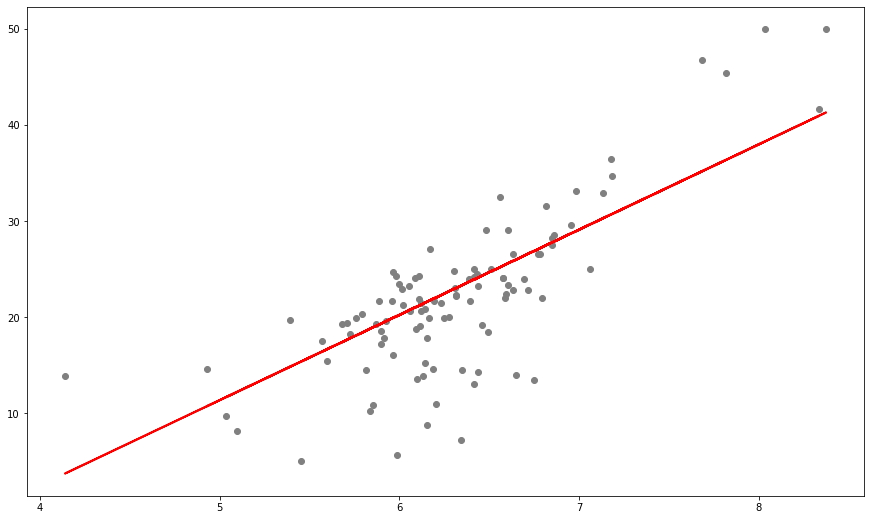

In [135]:
plt.figure(figsize=(15,9))
plt.scatter(testX, testY, color='grey')
plt.plot(testX, pred_uniRM_y, color='red', linewidth=2)

This uses our reliable plotting package matplotlib and pyplot to first, produce a scatterplot of our testing data (X,Y) pairs, then draw a blue line for our model/hypothesis. What information does the plot visualise?

Another interesting visualisation and based on the same information is the residual plot, which shows what is the difference in predicted and actual values, across different X values, for the testing data;

### Order 4 Polynomial Regression

To implement order 4 Polynomial Regression, please have a look at this documentation: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

First,  import PolynomialFeatures

In [136]:
from sklearn.preprocessing import PolynomialFeatures

#### STEP #1: Determining the degree of the polynomial

In [137]:
poly_feature=PolynomialFeatures(degree=4)

'''degree''' sets the degree of our polynomial function. degree=4 means that we want to work with a 4th degree polynomial! RECALL what is the formulation of 4th degree polynominal???

#### STEP #2: Creating the new features

There’s only one method – fit_transform() – but in fact it’s an amalgam of two separate methods: fit() and transform(). fit_transform() is a shortcut for using both at the same time, because they’re often used together.

Since I want you to understand what’s happening under the hood, I’ll show them to you separately.

With fit() we basically just declare what feature we want to transform:

In [138]:
X_poly=poly_feature.fit_transform(trainX)

There’s only one method – fit_transform() – but in fact it’s an amalgam of two separate methods: fit() and transform(). fit_transform() is a shortcut for using both at the same time, because they’re often used together.

Since I want you to understand what’s happening under the hood, we try them separately.

With fit() we basically just declare what feature we want to transform:

In [139]:
poly_feature.fit(trainX)

PolynomialFeatures(degree=4)

transform() performs the actual transformation:

In [140]:
poly_feature.transform(trainX)

array([[1.00000000e+00, 7.80200000e+00, 6.08712040e+01, 4.74917134e+02,
        3.70530348e+03],
       [1.00000000e+00, 5.71300000e+00, 3.26383690e+01, 1.86463002e+02,
        1.06526313e+03],
       [1.00000000e+00, 6.38200000e+00, 4.07299240e+01, 2.59938375e+02,
        1.65892671e+03],
       ...,
       [1.00000000e+00, 5.88800000e+00, 3.46685440e+01, 2.04128387e+02,
        1.20190794e+03],
       [1.00000000e+00, 5.80300000e+00, 3.36748090e+01, 1.95414917e+02,
        1.13399276e+03],
       [1.00000000e+00, 4.62800000e+00, 2.14183840e+01, 9.91242812e+01,
        4.58747173e+02]])

What are these numbers? Well, remind that we wanted to create x^4 values from our x values. In the second column we have our values for x. In the second column we have our values for x squared, ect.

Looks familiar? Our 4th degree polynomial formula, again:

y = theta_0 + theta_1*x + theta_2*x^2 + theta_3*x^3 + theta_4*x^4

 We save the result to X_poly:

In [141]:
#poly_reg.fit(X_poly,trainY)
X_poly=poly_feature.fit_transform(trainX)
print(X_poly)

[[1.00000000e+00 7.80200000e+00 6.08712040e+01 4.74917134e+02
  3.70530348e+03]
 [1.00000000e+00 5.71300000e+00 3.26383690e+01 1.86463002e+02
  1.06526313e+03]
 [1.00000000e+00 6.38200000e+00 4.07299240e+01 2.59938375e+02
  1.65892671e+03]
 ...
 [1.00000000e+00 5.88800000e+00 3.46685440e+01 2.04128387e+02
  1.20190794e+03]
 [1.00000000e+00 5.80300000e+00 3.36748090e+01 1.95414917e+02
  1.13399276e+03]
 [1.00000000e+00 4.62800000e+00 2.14183840e+01 9.91242812e+01
  4.58747173e+02]]


#### STEP #3: Creating the polynomial regression model

Now it’s time to create our machine learning model. Of course, we need to import it first:

In [142]:
from sklearn.linear_model import LinearRegression

Hold up a minute! 😮 Isn’t this tutorial supposed to be about polynomial regression? Why are we importing LinearRegression then?

Just think back to what you’ve read not so long ago: polynomial regression is a linear model, that’s why we import LinearRegression. 🙂

Let’s save an instance of LinearRegression to a variable:

In [143]:
polyReg = LinearRegression()

Then we fit our model to our data:

In [144]:
polyReg.fit(X_poly, trainY)

LinearRegression()

In [145]:
print(polyReg.intercept_)
print(polyReg.coef_)

-437.28644342944864
[   0.          356.56643183 -100.51437085   12.03366699   -0.51261655]


Now that our model is properly trained, we can put it to work by instructing it to predict the responses (y_predicted) based on poly_feature, and the coefficients it had estimated.

Prepare the data of test for Polynomial!!!

In [146]:
X_test_poly=poly_feature.fit_transform(testX)
print(X_test_poly)

[[1.00000000e+00 6.11400000e+00 3.73809960e+01 2.28547410e+02
  1.39733886e+03]
 [1.00000000e+00 6.51100000e+00 4.23931210e+01 2.76021611e+02
  1.79717671e+03]
 [1.00000000e+00 6.10800000e+00 3.73076640e+01 2.27875212e+02
  1.39186179e+03]
 [1.00000000e+00 5.98100000e+00 3.57723610e+01 2.13954491e+02
  1.27966181e+03]
 [1.00000000e+00 6.34300000e+00 4.02336490e+01 2.55202036e+02
  1.61874651e+03]
 [1.00000000e+00 5.92700000e+00 3.51293290e+01 2.08211533e+02
  1.23406976e+03]
 [1.00000000e+00 6.45800000e+00 4.17057640e+01 2.69335824e+02
  1.73937075e+03]
 [1.00000000e+00 6.49500000e+00 4.21850250e+01 2.73991737e+02
  1.77957633e+03]
 [1.00000000e+00 6.43300000e+00 4.13834890e+01 2.66219985e+02
  1.71259316e+03]
 [1.00000000e+00 6.38900000e+00 4.08193210e+01 2.60794642e+02
  1.66621697e+03]
 [1.00000000e+00 6.84900000e+00 4.69088010e+01 3.21278378e+02
  2.20043561e+03]
 [1.00000000e+00 6.27900000e+00 3.94258410e+01 2.47554856e+02
  1.55439694e+03]
 [1.00000000e+00 6.81600000e+00 4.645785

In [40]:
pred_uniRM_y_poly = polyReg.predict(X_test_poly)

### Fit the two models and evaluate their MSE. Which model performs better and why?

In [79]:
from sklearn.metrics import mean_squared_error
print('Mean squared error of linear regression ', mean_squared_error(testY, pred_uniRM_y))
print('Mean squared error of 4th order polynominal regression ', mean_squared_error(testY, pred_uniRM_y_poly))

Mean squared error of linear regression  33.43158389456608
Mean squared error of 4th order polynominal regression  33.00778361135058


### Let’s do some dataviz to see what our model looks like

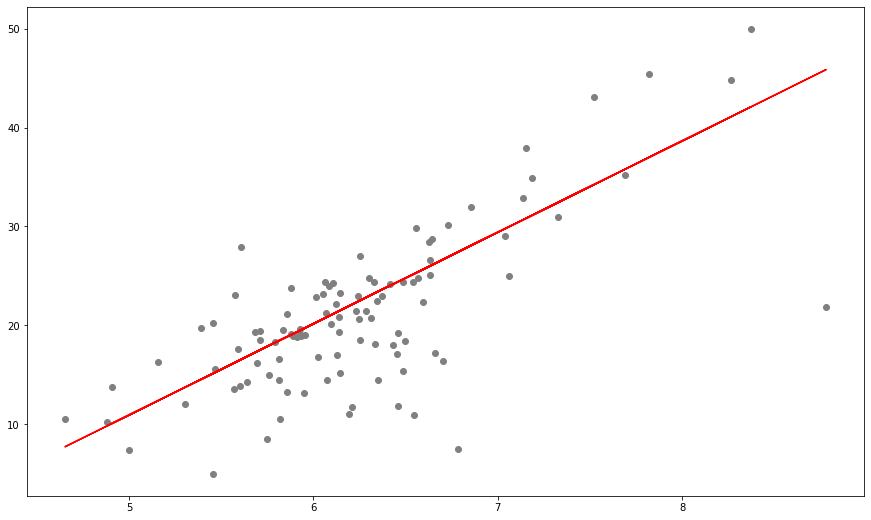

In [80]:
plt.figure(figsize=(15,9))

#plot the linear model
plt.scatter(testX, testY, color='grey')
plt.plot(testX, pred_uniRM_y, color='red', linewidth=1.5)


In [147]:
x_min = min(testX.iloc[:,:].values)[0]
x_max = max(testX.iloc[:,:].values)[0]
print(x_min, x_max) 
X_grid=np.arange(x_min,x_max,0.1)
X_grid=X_grid.reshape((len(X_grid),1))

4.138 8.375


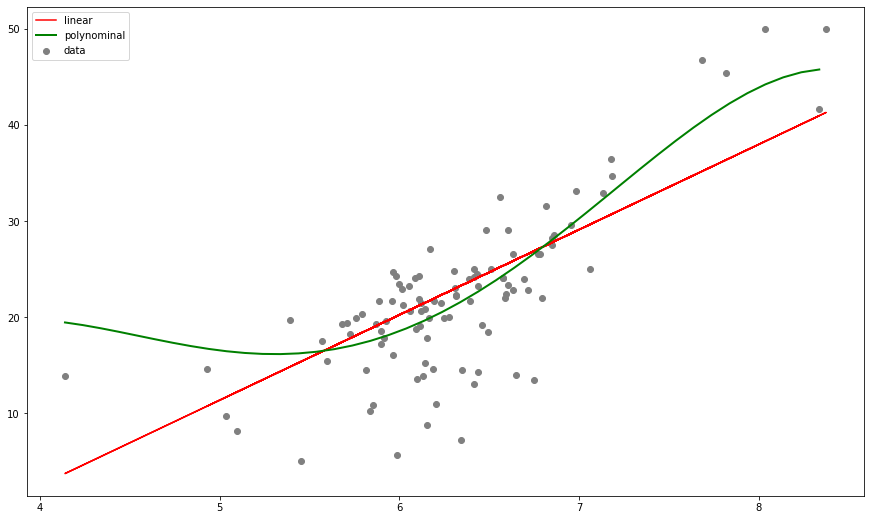

In [150]:
plt.figure(figsize=(15,9))

#plot the linear model
plt.scatter(testX, testY, color='grey')
plt.plot(testX, pred_uniRM_y, color='red', linewidth=1.5)

#plot the 4th order polynominal model
X_grid_poly= poly_feature.fit_transform(X_grid)
pred_uniRM_y_grid_poly = polyReg.predict(X_grid_poly)
plt.plot(X_grid, pred_uniRM_y_grid_poly, color='green', linewidth=2)
plt.legend(['linear','polynominal', 'data'])

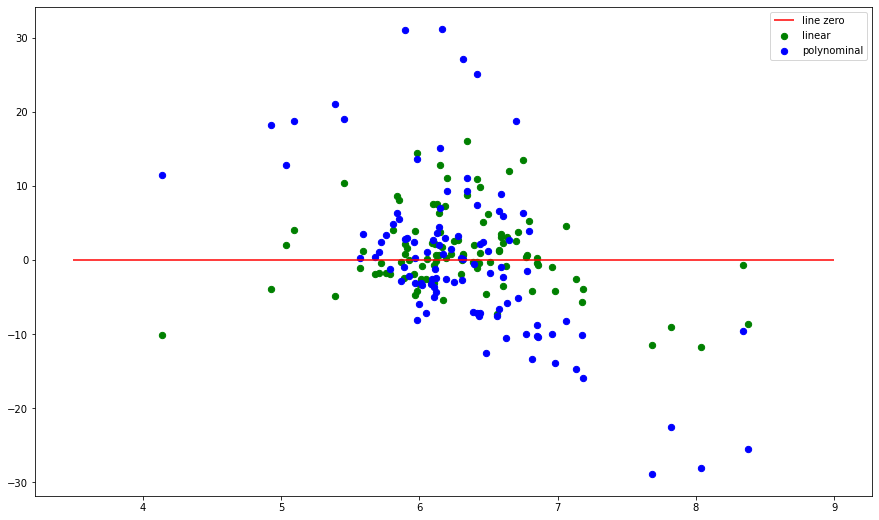

In [151]:
plt.figure(figsize=(15,9))
plt.hlines(y=0, xmin=3.5, xmax=9, colors = 'red')
plt.scatter(testX, linReg.predict(testX) - testY, c='g', s=40)
plt.scatter(testX, pred_uniRM_y_poly - testY, c='b', s=40)
plt.legend(['line zero','linear', 'polynominal'])

If the model is perfect, then for each testing data then there is 0 residual (or 0 error between predicted versus actual), which is represented by the horizontal line in the diagram. If the model under-estimates the actual value, it will be below this horizontal line, and if over-estimates, than above. This plot can quickly give you a sense of where the errors are occurring and whether there are outlier points that are causing large errors (we will examine this later in the course and ways to deal with this).


> **<font color='red'><span style="font-size:1.5em;">☞</span> With your dataframe slicing skill, can you count the number of residuals that are larger than zero and those that are smaller than zero?





## Further exercies
We have fitted a linear regression model/hypothesis for the ‘RM’ variable. Use the seaborn package to visualise the correlation plot and identify the next potential predictor of the house price. You should identify 'LSTAT' as the next potential predictor. Why is it?

Repeat the above analysis using the ‘LSTAT’ variable, and comment on which predictor you think is performing better. LSTAT variable has a negative (inverse) linear relationship with ‘MEDV’, where when LSTAT increases MEDV decreases – do you think it matters?





## Multivariate Regression

So far, we have only used one X variable to predict MEDV. What if we used all the variables? To create such data, we first do the following:



In [17]:
house_multi_X = bostonHouseFrame.drop('MEDV', axis=1)
house_multi_Y = bostonHouseFrame[['MEDV']]

In [18]:
print(house_multi_X.shape)
print(house_multi_Y.shape)

(506, 13)
(506, 1)


In [20]:
train_multi_X, test_multi_X, train_multi_Y, test_multi_Y = train_test_split(house_multi_X, house_multi_Y, test_size=0.2,shuffle=True)

The Y variable is the same, but the X variable is interesting. We use the drop() method of data frames, which essentially drops a column from it – in our case, we drop the ‘MEDV’ column. X is now a data frame without the MEDV column, print it out the check.

Now repeat the same analysis, noting that train_test_split(), linReg.fit() and linReg.predict() can work with multivariate linear regression (i.e. where we have multiple X variables) as well. Make sure you print out the intercept and coefficients, print(linReg.intercept_) print(linReg.coef_), to see what are the fits and do the mean squared error.

In [31]:
from sklearn import linear_model
multi_linReg = linear_model.LinearRegression()

In [32]:
history = multi_linReg.fit(train_multi_X, train_multi_Y)

In [33]:
print(history)

LinearRegression()


# Regularization - Lasso Polynomial Regression 

> **<font color='red'><span style="font-size:1.5em;">☞</span> Goal: Do some regularization techniques on polynomial regression. 
    
We will be using the Lasso polynomial regression model. Recall that Lasso regularisation (L1) has a regularisation weight that determines the weighting placed on regularisation. We use the following regularisation weights to evaluate which one is best for the regularisation weight in your constructed lasso polynomial regression.

- alpha = 0.01
- alpha = 0.05
- alpha = 0.1
- alpha = 0.25
- alpha = 0.5
- alpha = 0.75
- alpha = 1

Refer to the documentation about L1 regularisation to understand how to modify the polyminal regression model with the alpha parameter: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Build seven different Lasso polynomial regression models with the above alpha parameters and evaluate which one works best (based on MSE).</font>**
    
> **<font color='red'><span style="font-size:1.5em;">☞</span> Question: Keep the order of polynomial the same (i.e., 4). What is the alpha parameter that leads to the best model? </font>**

In order to do model selection with different regularisation alpha values, we first store the alpha values in a list:

In [90]:
alpha_RegPara = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]

In [93]:
#just remind that we already have X_train, Y_train
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(house_uniRM_x, house_y, test_size=0.2,shuffle=True)

First, we need to import Lasso from linear regesstion model

In [91]:
from sklearn.linear_model import Lasso

And prapare data for training and validation

In [107]:
# We need to have lists to store our results
final_results = []

# Create the train and the validation sets based on the existing training set
#for trainIndex, validIndex in kFold.split(X_train, Y_train):
# Use 20% of the existing train set to make the validation set
trainX = np.array(X_train.iloc[:])
trainY = np.array(Y_train.iloc[:])
validX = np.array(X_train.iloc[:])
validY = np.array(Y_train.iloc[:])

print(trainX.shape)
print(validX.shape)
#print(trainX)
#print(validX)  


(404, 1)
(404, 1)


[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
---------------------------------------------------



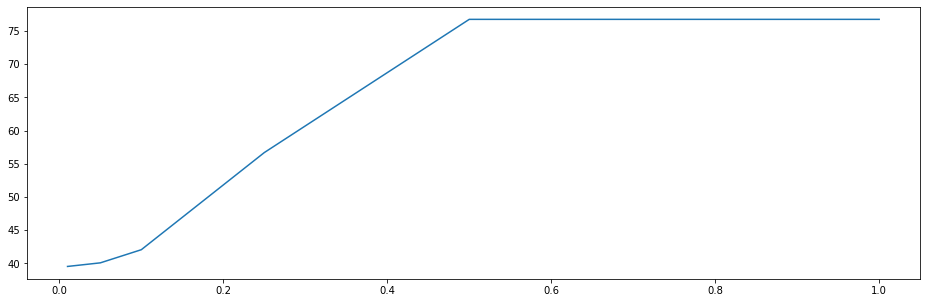

In [113]:
# We have the training and validation data now
# We gonna train each model with each alphas by using these training data
# And then we are going to evaluate MSE of the models by applying them on the validation data
# To store the results of each alphas
lResults = []
lModels = []
for regPara in alpha_RegPara:
    ### TRAINING THE LASSO MODEL
    # Create the polynomial regression object
    polyLassoReg = Lasso(alpha = regPara, normalize = True)

    # Create, then fit and transform at the same time trainX by using the poly_feat object
    polyFitTrainX = poly_feature.fit_transform(trainX)
    
    # Fit the model
    polyLassoReg.fit(polyFitTrainX, trainY)

    ### VALIDATE THE LASSO MODEL WITH THE VALIDATION DATA
    # Create, then fit and transform at the same time validationX by using the poly_feat object
    
    polyFitValidX = poly_feature.fit_transform(validX)
    # Predict Y by using the validation set
    
    predY = polyLassoReg.predict(polyFitValidX)
    # Calculate the MSE
    
    mse = mean_squared_error(predY, validY)
    # Store the MSE result of the current model
    lResults.append(mse)
    
print(alpha_RegPara)
print("---------------------------------------------------")
print("")
final_results.append(lResults)
plt.figure(figsize=(16,5))
plt.plot(alpha_RegPara, lResults)

## K-Fold Cross Validation

We will now use k-fold cross validation to evaluate parameters and to perform testing performance. 

Consider the following code to setup 5-fold cross validation:

In [110]:
from sklearn import model_selection

kFold = model_selection.KFold(n_splits=5, shuffle=True)

The shuffle parameter of KFold() randomly shuffles the data before performing the splits. You may want to do some extra reading to understand how to use KFold().

[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
Fold 1 [43.472378535703044, 43.86368953301328, 45.84184473710903, 61.02691184502629, 81.9132176794942, 81.9132176794942, 81.9132176794942]
---------------------------------------------------

[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
Fold 2 [32.473640332921754, 33.307011222614925, 35.27775494629084, 47.38352019438167, 64.00090527129927, 64.00090527129927, 64.00090527129927]
---------------------------------------------------

[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
Fold 3 [71.56703248311118, 69.23527029882041, 68.8819257143263, 84.89761293330662, 113.13951085058673, 113.13951085058673, 113.13951085058673]
---------------------------------------------------

[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
Fold 4 [36.074473886609276, 36.53182555555119, 38.09960955972529, 49.44359102555895, 66.25649762402865, 66.25649762402865, 66.25649762402865]
---------------------------------------------------

[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
Fold 5 [35.328619622680684, 39.

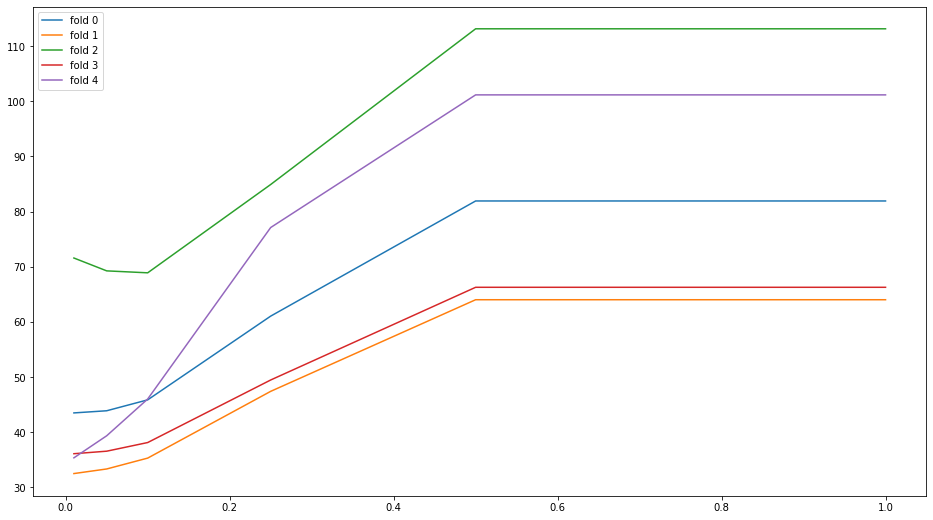

In [121]:
# We need to have lists to store our results
final_results = []
i = 0
plt.figure(figsize=(16,9))
# Create the train and the validation sets based on the existing training set
for trainIndex, validIndex in kFold.split(X_train, Y_train):
    # Use 20% of the existing train set to make the validation set
    trainX = np.array(X_train.iloc[trainIndex])
    trainY = np.array(Y_train.iloc[trainIndex])
    validX = np.array(X_train.iloc[validIndex])
    validY = np.array(Y_train.iloc[validIndex])
    
    #print(trainX.shape)
    #print(validX.shape)
    #print(trainX)
    #print(validX)
    
    # We have the training and validation data now
    # We gonna train each model with each alphas by using these training data
    # And then we are going to evaluate MSE of the models by applying them on the validation data
    
    # To store the results of each alphas
    lResults = []
    lModels = []
    
    for regPara in alpha_RegPara:
        ### TRAINING THE LASSO MODEL
        # Create the polynomial regression object
        polyLassoReg = Lasso(alpha = regPara, normalize = True)
        
        # Create, then fit and transform at the same time trainX by using the poly_feat object
        polyFitTrainX = poly_feature.fit_transform(trainX)
        
        # Fit the model
        polyLassoReg.fit(polyFitTrainX, trainY)
        
        ### VALIDATE THE LASSO MODEL WITH THE VALIDATION DATA
        # Create, then fit and transform at the same time validationX by using the poly_feat object
        polyFitValidX = poly_feature.fit_transform(validX)
        
        # Predict Y by using the validation set
        predY = polyLassoReg.predict(polyFitValidX)
        
        # Calculate the MSE
        mse = mean_squared_error(predY, validY)
        
        # Store the MSE result of the current model
        lResults.append(mse)
        
    i = i + 1
    
    print(alpha_RegPara)
    print("Fold",i,lResults)
    print("---------------------------------------------------")
    print("")
    final_results.append(lResults)
    plt.plot(alpha_RegPara, lResults)
    plt.legend(['fold ' + str(i) for i in range(5)])

In [120]:
print(['fold ' + str(i) for i in range(5)])

['fold 0', 'fold 1', 'fold 2', 'fold 3', 'fold 4']


Modify the code above to output an average (and std. dev.) of the results and plot it. 
Use this result to help select the regularisation parameter setting. 

> **<font color='red'><span style="font-size:1.5em;">☞</span> What is the alpha value that we should use for our Lasso polynomial model and why?</font>**

> **<font color='red'><span style="font-size:1.5em;">☞</span>Your next task is to adjust the order of polynomial to 2 and 3 and evaluate the results. Do these models perform better than the order 4 polynomial model?</font>**

> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Work with multivariate regresstion!!!</font>**  

# Exercise: Work on the Bike Share Data

> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Do the linear regression on the Bike Share Data.</font>**  
> Now you seen how to do this task for the house price dataset. Repeat the same process for the Daily
Bike Share rental data.
